In [1]:
import hail as hl

In [2]:
hl.init()

Running on Apache Spark version 2.4.1
SparkUI available at http://100.64.10.24:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.31-6060f9c971cc
LOGGING: writing to /Users/pargol_gheissari/Documents/Documents/Cornell_Tech/SDL_Project/hail-20200324-0841-0.2.31-6060f9c971cc.log


In [3]:
from hail.plot import show
from pprint import pprint
hl.plot.output_notebook()

Loading BokehJS ...

In [4]:
#Download data
hl.utils.get_1kg('data/')

2020-03-24 08:42:00 Hail: INFO: 1KG files found


In [5]:
#Import data from vcf 
hl.import_vcf('data/1kg.vcf.bgz').write('data/1kg.mt', overwrite=True)

2020-03-24 08:42:03 Hail: INFO: Coerced sorted dataset
2020-03-24 08:42:06 Hail: INFO: wrote matrix table with 10961 rows and 284 columns in 2 partitions to data/1kg.mt


In [6]:
mt = hl.read_matrix_table('data/1kg.mt')

In [7]:
#Show data
mt.rows().select().show(5)

locus,alleles
locus<GRCh37>,array<str>
1:904165,"[""G"",""A""]"
1:909917,"[""G"",""A""]"
1:986963,"[""C"",""T""]"
1:1563691,"[""T"",""G""]"
1:1707740,"[""T"",""G""]"


In [8]:
table = (hl.import_table('data/1kg_annotations.txt', impute=True)
         .key_by('Sample'))

2020-03-24 08:42:06 Hail: INFO: Reading table to impute column types
2020-03-24 08:42:06 Hail: INFO: Finished type imputation
  Loading column 'Sample' as type 'str' (imputed)
  Loading column 'Population' as type 'str' (imputed)
  Loading column 'SuperPopulation' as type 'str' (imputed)
  Loading column 'isFemale' as type 'bool' (imputed)
  Loading column 'PurpleHair' as type 'bool' (imputed)
  Loading column 'CaffeineConsumption' as type 'int32' (imputed)


In [9]:
table.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'Sample': str 
    'Population': str 
    'SuperPopulation': str 
    'isFemale': bool 
    'PurpleHair': bool 
    'CaffeineConsumption': int32 
----------------------------------------
Key: ['Sample']
----------------------------------------


In [10]:
table.show(width=100)

Sample,Population,SuperPopulation,isFemale,PurpleHair,CaffeineConsumption
str,str,str,bool,bool,int32
"""HG00096""","""GBR""","""EUR""",false,false,4
"""HG00097""","""GBR""","""EUR""",true,true,4
"""HG00098""","""GBR""","""EUR""",false,false,5
"""HG00099""","""GBR""","""EUR""",true,false,4
"""HG00100""","""GBR""","""EUR""",true,false,5
"""HG00101""","""GBR""","""EUR""",false,true,1
"""HG00102""","""GBR""","""EUR""",true,true,6
"""HG00103""","""GBR""","""EUR""",false,true,5
"""HG00104""","""GBR""","""EUR""",true,false,5


In [11]:
mt = mt.annotate_cols(pheno = table[mt.s])
mt.col.describe()

--------------------------------------------------------
Type:
        struct {
        s: str, 
        pheno: struct {
            Population: str, 
            SuperPopulation: str, 
            isFemale: bool, 
            PurpleHair: bool, 
            CaffeineConsumption: int32
        }
    }
--------------------------------------------------------
Source:
Index:
    ['column']
--------------------------------------------------------


In [12]:
#Aggregate rows of table, counts the number of occurrences of each unique element
pprint(table.aggregate(hl.agg.counter(table.SuperPopulation)))

{'AFR': 1018, 'AMR': 535, 'EAS': 617, 'EUR': 669, 'SAS': 661}


In [13]:
#See distribution
pprint(table.aggregate(hl.agg.stats(table.CaffeineConsumption)))

{'max': 10.0,
 'mean': 3.9837142857142855,
 'min': -1.0,
 'n': 3500,
 'stdev': 1.7021055628070711,
 'sum': 13943.0}


In [14]:
#Fewer samples in our dataset than in the full 1000genomes cohort, look at annotations on the dataset
mt.aggregate_cols(hl.agg.counter(mt.pheno.SuperPopulation))
pprint(mt.aggregate_cols(hl.agg.stats(mt.pheno.CaffeineConsumption)))

{'max': 9.0,
 'mean': 4.415492957746479,
 'min': 0.0,
 'n': 284,
 'stdev': 1.577763427465917,
 'sum': 1254.0}


In [15]:
#Count each 12 possible unique SNPS
snp_counts = mt.aggregate_rows(hl.agg.counter(hl.Struct(ref=mt.alleles[0], alt=mt.alleles[1])))
pprint(snp_counts)

{Struct(ref='A', alt='G'): 1944,
 Struct(ref='C', alt='A'): 496,
 Struct(ref='A', alt='C'): 454,
 Struct(ref='C', alt='T'): 2436,
 Struct(ref='C', alt='G'): 150,
 Struct(ref='A', alt='T'): 76,
 Struct(ref='G', alt='A'): 2387,
 Struct(ref='G', alt='C'): 112,
 Struct(ref='T', alt='G'): 468,
 Struct(ref='G', alt='T'): 480,
 Struct(ref='T', alt='C'): 1879,
 Struct(ref='T', alt='A'): 79}


In [16]:
#counts in descending order
from collections import Counter
counts = Counter(snp_counts)
counts.most_common()

[(Struct(ref='C', alt='T'), 2436),
 (Struct(ref='G', alt='A'), 2387),
 (Struct(ref='A', alt='G'), 1944),
 (Struct(ref='T', alt='C'), 1879),
 (Struct(ref='C', alt='A'), 496),
 (Struct(ref='G', alt='T'), 480),
 (Struct(ref='T', alt='G'), 468),
 (Struct(ref='A', alt='C'), 454),
 (Struct(ref='C', alt='G'), 150),
 (Struct(ref='G', alt='C'), 112),
 (Struct(ref='T', alt='A'), 79),
 (Struct(ref='A', alt='T'), 76)]

In [17]:
p = hl.plot.histogram(mt.DP, range=(0,30), bins=30, title='DP Histogram', legend='DP')
show(p)

In [18]:
#Plotting QC metrics
mt = hl.sample_qc(mt)
p = hl.plot.histogram(mt.sample_qc.call_rate, range=(.88,1), legend='Call Rate')
show(p)

## Add health predisposition

In [19]:
num_rows = table.count()
print("Number of rows in the table: ", num_rows)

Number of rows in the table:  3500


In [20]:
health_pred = ["Type_2_Diabetes", "Age-Related_Macular_Degeneration", "Alpha-1_Antitrypsin_Deficiency", "BRCA1/BRCA2",
              "Celiac_Disease", "Familial_Hypercholesterolemia", "G6PD_Deficiency", "Hereditary_Amyloidosis(TTR-Related)",
              "Hereditary_Hemochromatosis(HFE‑Related)", "Hereditary_Thrombophilia", "Late-Onset_Alzheimers_Disease", "MUTYH-Associated_Polyposis",
              "Parkinsons_Disease"]
print("Number of health predispositions: ", len(health_pred))

Number of health predispositions:  13


In [21]:
import random
rand_health_pred = [random.choice(health_pred) for i in range(num_rows)]

In [22]:
# turn hail table into pandas df 
genome_pd_df = table.to_pandas()

In [23]:
# add predisposition list to pandas table
#genome_pd_df['Health Pred'] = rand_health_pred

In [24]:
genome_pd_df

,Sample,Population,SuperPopulation,isFemale,PurpleHair,CaffeineConsumption
0,HG00096,GBR,EUR,False,False,4
1,HG00097,GBR,EUR,True,True,4
2,HG00098,GBR,EUR,False,False,5
3,HG00099,GBR,EUR,True,False,4
4,HG00100,GBR,EUR,True,False,5
...,...,...,...,...,...,...
3495,NA21137,GIH,SAS,True,False,1
3496,NA21141,GIH,SAS,True,True,2
3497,NA21142,GIH,SAS,True,True,2
3498,NA21143,GIH,SAS,True,True,5


In [25]:
for item in health_pred:
    genome_pd_df[item] = [random.choice([True, False]) for i in range(num_rows)]

In [26]:
genome_pd_df

,Sample,Population,SuperPopulation,isFemale,PurpleHair,CaffeineConsumption,Type_2_Diabetes,Age-Related_Macular_Degeneration,Alpha-1_Antitrypsin_Deficiency,BRCA1/BRCA2,Celiac_Disease,Familial_Hypercholesterolemia,G6PD_Deficiency,Hereditary_Amyloidosis(TTR-Related),Hereditary_Hemochromatosis(HFE‑Related),Hereditary_Thrombophilia,Late-Onset_Alzheimers_Disease,MUTYH-Associated_Polyposis,Parkinsons_Disease
0,HG00096,GBR,EUR,False,False,4,True,False,True,False,False,False,True,False,True,True,True,False,True
1,HG00097,GBR,EUR,True,True,4,False,False,False,True,True,True,True,True,False,True,False,False,False
2,HG00098,GBR,EUR,False,False,5,True,False,True,True,False,False,True,False,True,False,False,False,False
3,HG00099,GBR,EUR,True,False,4,False,False,True,True,False,True,False,False,True,True,True,True,True
4,HG00100,GBR,EUR,True,False,5,True,False,False,False,False,True,False,True,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,NA21137,GIH,SAS,True,False,1,True,True,True,True,True,True,True,False,True,True,False,True,True
3496,NA21141,GIH,SAS,True,True,2,True,False,False,False,True,True,True,False,True,True,True,True,False
3497,NA21142,GIH,SAS,True,True,2,False,False,False,False,True,False,True,False,True,False,False,False,True
3498,NA21143,GIH,SAS,True,True,5,False,True,False,True,False,True,False,True,False,True,False,True,True


In [27]:
mt.show()

locus,alleles
locus<GRCh37>,array<str>
1:904165,"[""G"",""A""]"
1:909917,"[""G"",""A""]"
1:986963,"[""C"",""T""]"
1:1563691,"[""T"",""G""]"
1:1707740,"[""T"",""G""]"
1:2252970,"[""C"",""T""]"
1:2284195,"[""T"",""C""]"
1:2779043,"[""T"",""C""]"
1:2944527,"[""G"",""A""]"


## Visualizations

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [29]:
superPopulations = genome_pd_df.SuperPopulation.unique()
print('SuperPopulations: ', superPopulations)
print('Number of Super Populations: ', len(superPopulations))
populations = genome_pd_df.Population.unique()
print('Populations: ', populations)
print('Number of Populations: ', len(populations))

SuperPopulations:  ['EUR' 'EAS' 'AMR' 'SAS' 'AFR']
Number of Super Populations:  5
Populations:  ['GBR' 'FIN' 'CHS' 'PUR' 'CDX' 'CLM' 'IBS' 'PEL' 'PJL' 'KHV' 'ACB' 'GWD'
 'ESN' 'BEB' 'MSL' 'STU' 'ITU' 'CEU' 'YRI' 'CHB' 'JPT' 'LWK' 'ASW' 'MXL'
 'TSI' 'GIH']
Number of Populations:  26


In [30]:
eur = genome_pd_df.loc[genome_pd_df['SuperPopulation'] == 'EUR']
eas = genome_pd_df.loc[genome_pd_df['SuperPopulation'] == 'EAS']
amr = genome_pd_df.loc[genome_pd_df['SuperPopulation'] == 'AMR']
sas = genome_pd_df.loc[genome_pd_df['SuperPopulation'] == 'SAS']
afr = genome_pd_df.loc[genome_pd_df['SuperPopulation'] == 'AFR']
eur

,Sample,Population,SuperPopulation,isFemale,PurpleHair,CaffeineConsumption,Type_2_Diabetes,Age-Related_Macular_Degeneration,Alpha-1_Antitrypsin_Deficiency,BRCA1/BRCA2,Celiac_Disease,Familial_Hypercholesterolemia,G6PD_Deficiency,Hereditary_Amyloidosis(TTR-Related),Hereditary_Hemochromatosis(HFE‑Related),Hereditary_Thrombophilia,Late-Onset_Alzheimers_Disease,MUTYH-Associated_Polyposis,Parkinsons_Disease
0,HG00096,GBR,EUR,False,False,4,True,False,True,False,False,False,True,False,True,True,True,False,True
1,HG00097,GBR,EUR,True,True,4,False,False,False,True,True,True,True,True,False,True,False,False,False
2,HG00098,GBR,EUR,False,False,5,True,False,True,True,False,False,True,False,True,False,False,False,False
3,HG00099,GBR,EUR,True,False,4,False,False,True,True,False,True,False,False,True,True,True,True,True
4,HG00100,GBR,EUR,True,False,5,True,False,False,False,False,True,False,True,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3382,NA20827,TSI,EUR,False,False,6,True,False,True,True,True,True,False,False,True,True,True,False,True
3383,NA20828,TSI,EUR,True,True,4,False,True,False,True,False,False,False,False,False,False,False,False,True
3384,NA20829,TSI,EUR,False,True,5,True,True,False,True,True,True,True,False,False,True,False,True,False
3385,NA20831,TSI,EUR,False,False,2,True,True,True,False,False,True,True,False,True,True,True,True,True


In [31]:
gbr = genome_pd_df.loc[genome_pd_df['Population'] == 'GBR']
fin = genome_pd_df.loc[genome_pd_df['Population'] == 'FIN']
chs = genome_pd_df.loc[genome_pd_df['Population'] == 'CHS']
pur = genome_pd_df.loc[genome_pd_df['Population'] == 'PUR']
cdx = genome_pd_df.loc[genome_pd_df['Population'] == 'CDX']
clm = genome_pd_df.loc[genome_pd_df['Population'] == 'CLM']

In [32]:
eur_true, eur_false = eur.Type_2_Diabetes.value_counts()
eas_true, eas_false = eas.Type_2_Diabetes.value_counts()
amr_true, amr_false = amr.Type_2_Diabetes.value_counts()
sas_true, sas_false = sas.Type_2_Diabetes.value_counts()
afr_true, afr_false = afr.Type_2_Diabetes.value_counts()

In [33]:
def count_occurence_country(df, continent, disease):
    continent = df.loc[df['SuperPopulation'] == continent]
    unique_countries = continent.Population.unique()
    disease_dict = {}
    for country in unique_countries:
        df_temp = df.loc[df['Population'] == country]
        true_freq, false_freq = df_temp[disease].value_counts()
        disease_dict[country] = true_freq
    return disease_dict

In [34]:
def plot_bar(input_dict):
    keys = input_dict.keys()
    values = input_dict.values()
    plt.bar(keys, values)

In [35]:
count_occurence_country = count_occurence_country(genome_pd_df, 'EUR', 'Type_2_Diabetes')

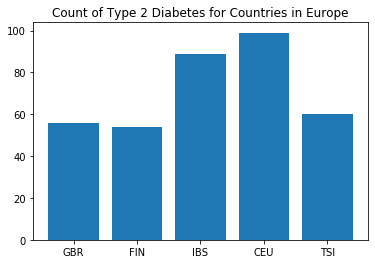

In [36]:
plt.title("Count of Type 2 Diabetes for Countries in Europe")
plot_bar(count_occurence_country)

In [37]:
def count_occurence_continents(df, disease):
    unique_continents = df.SuperPopulation.unique()
    disease_dict = {}
    for continent in unique_continents:
        df_temp = df.loc[df['SuperPopulation'] == continent]
        true_freq, false_freq = df_temp[disease].value_counts()
        disease_dict[continent] = true_freq
    return disease_dict

In [38]:
count_occurence_continents = count_occurence_continents(genome_pd_df, 'Type_2_Diabetes')

In [39]:
count_occurence_continents

{'EUR': 338, 'EAS': 310, 'AMR': 280, 'SAS': 331, 'AFR': 512}

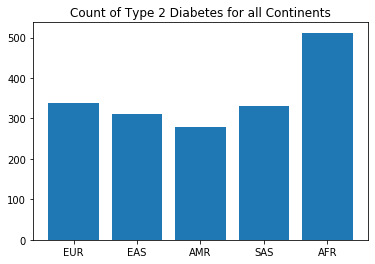

In [40]:
plt.title("Count of Type 2 Diabetes for all Continents")
plot_bar(count_occurence_continents)

In [41]:
def count_occurence_allDisease(df, health_pred):
    unique_continents = df.SuperPopulation.unique()
    disease_dict = {}
    for continent in unique_continents: 
            df_temp = df.loc[df['SuperPopulation'] == continent]
            disease_dict[continent] = {}
            for disease in health_pred:
                true_freq, false_freq = df_temp[disease].value_counts()
                disease_dict[continent][disease] = true_freq
    return disease_dict

In [42]:
count_allDisease = count_occurence_allDisease(genome_pd_df, health_pred)

In [43]:
diseaseGlobe_df = pd.DataFrame.from_dict(count_allDisease, orient="index")
diseaseGlobe_df

,Type_2_Diabetes,Age-Related_Macular_Degeneration,Alpha-1_Antitrypsin_Deficiency,BRCA1/BRCA2,Celiac_Disease,Familial_Hypercholesterolemia,G6PD_Deficiency,Hereditary_Amyloidosis(TTR-Related),Hereditary_Hemochromatosis(HFE‑Related),Hereditary_Thrombophilia,Late-Onset_Alzheimers_Disease,MUTYH-Associated_Polyposis,Parkinsons_Disease
EUR,338,347,344,365,343,336,338,344,337,340,338,347,336
EAS,310,314,326,312,317,320,310,312,310,311,309,331,310
AMR,280,290,290,277,286,269,278,268,281,268,281,273,275
SAS,331,340,340,332,333,344,332,336,334,340,351,336,337
AFR,512,511,512,556,522,519,534,525,517,512,512,523,515


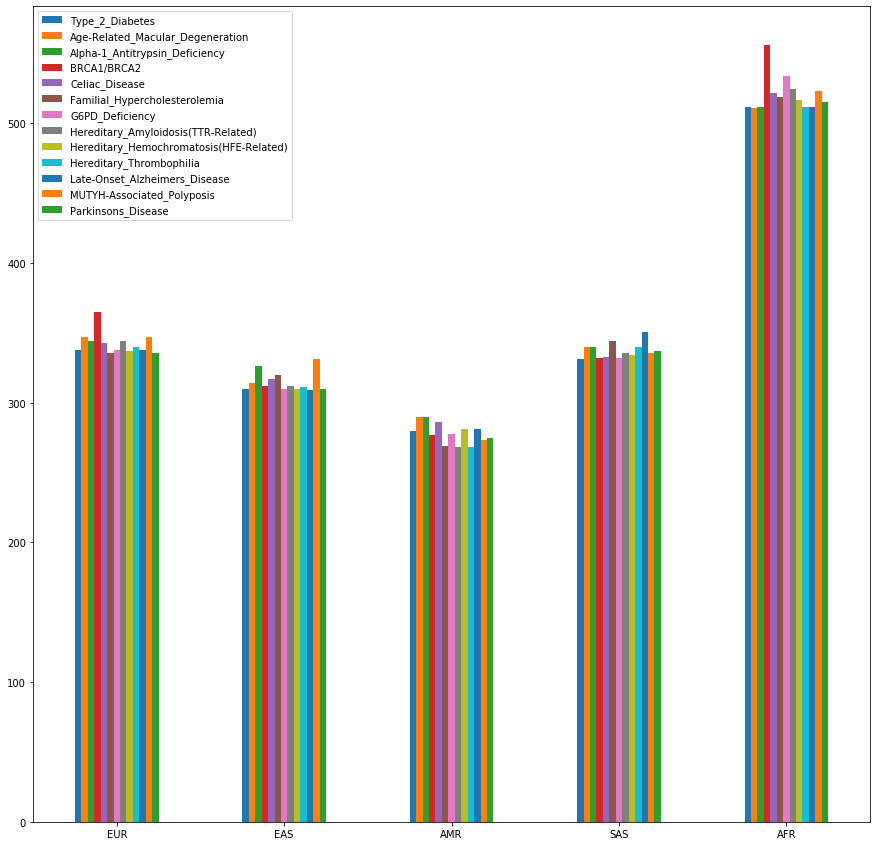

In [44]:
ax = diseaseGlobe_df.plot.bar(figsize = (15,15), rot=0)

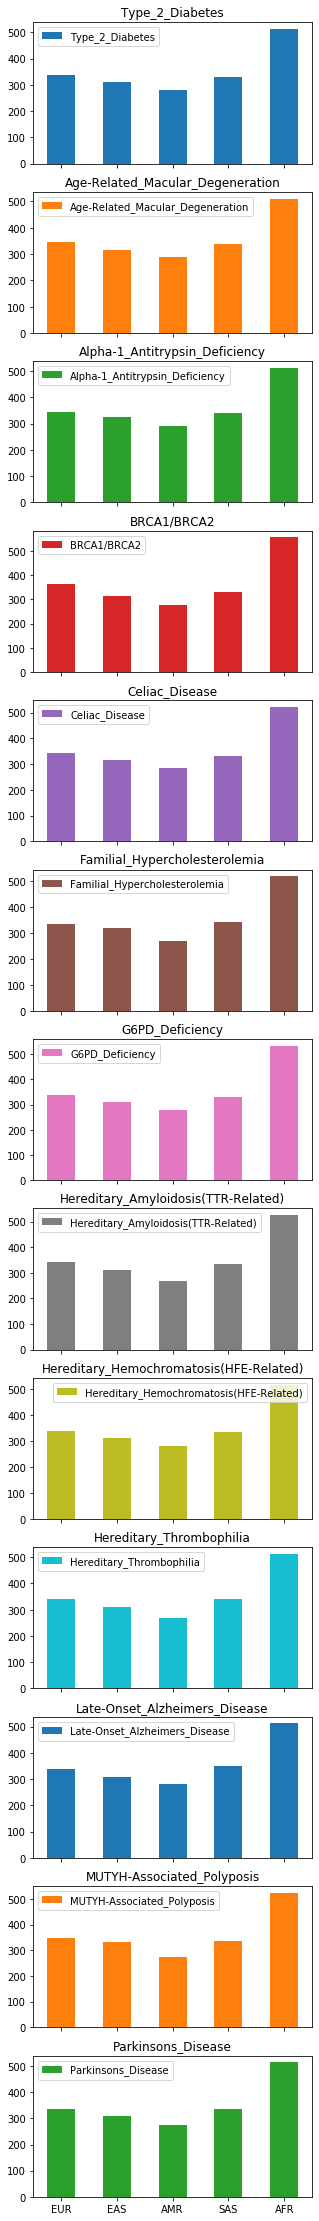

In [45]:
axes = diseaseGlobe_df.plot.bar(figsize = (5,40), rot=0, subplots=True)
axes[1].legend(loc=2)

In [46]:
correlation_df = genome_pd_df.corr()
correlation_df

,isFemale,PurpleHair,CaffeineConsumption,Type_2_Diabetes,Age-Related_Macular_Degeneration,Alpha-1_Antitrypsin_Deficiency,BRCA1/BRCA2,Celiac_Disease,Familial_Hypercholesterolemia,G6PD_Deficiency,Hereditary_Amyloidosis(TTR-Related),Hereditary_Hemochromatosis(HFE‑Related),Hereditary_Thrombophilia,Late-Onset_Alzheimers_Disease,MUTYH-Associated_Polyposis,Parkinsons_Disease
isFemale,1.000000,0.014095,-0.004478,-0.007406,0.005701,0.006342,0.028311,0.027846,0.010325,-0.002332,0.006270,0.009098,0.011396,-0.013120,-0.014263,-0.004076
PurpleHair,0.014095,1.000000,0.009908,-0.003291,-0.024666,0.016349,0.030800,0.004703,0.000811,-0.013430,-0.011535,0.006011,-0.007633,-0.007865,-0.012440,-0.009608
CaffeineConsumption,-0.004478,0.009908,1.000000,0.016244,0.024362,-0.002611,0.006051,-0.031460,-0.023734,-0.017214,0.011945,-0.028628,-0.026635,0.014901,-0.008599,-0.007429
Type_2_Diabetes,-0.007406,-0.003291,0.016244,1.000000,0.026867,-0.012611,0.019094,-0.039901,0.008544,0.006318,0.002297,-0.016540,0.008594,0.025127,-0.041160,-0.003376
Age-Related_Macular_Degeneration,0.005701,-0.024666,0.024362,0.026867,1.000000,-0.014264,-0.001265,-0.008642,-0.021699,-0.000018,0.022279,0.007982,0.001130,0.001723,0.014295,-0.008602
Alpha-1_Antitrypsin_Deficiency,0.006342,0.016349,-0.002611,-0.012611,-0.014264,1.000000,-0.003494,0.012861,-0.000638,0.017793,-0.001115,-0.003923,0.007485,0.010247,0.018248,-0.007873
BRCA1/BRCA2,0.028311,0.030800,0.006051,0.019094,-0.001265,-0.003494,1.000000,-0.012412,-0.008795,-0.006144,-0.015600,0.019035,0.014577,-0.001506,-0.022106,0.006748
Celiac_Disease,0.027846,0.004703,-0.031460,-0.039901,-0.008642,0.012861,-0.012412,1.000000,-0.020952,-0.016812,-0.017234,0.011772,-0.003025,-0.028467,-0.007887,0.006477
Familial_Hypercholesterolemia,0.010325,0.000811,-0.023734,0.008544,-0.021699,-0.000638,-0.008795,-0.020952,1.000000,-0.025089,-0.031410,0.019485,0.008040,-0.001742,-0.015456,0.006377
G6PD_Deficiency,-0.002332,-0.013430,-0.017214,0.006318,-0.000018,0.017793,-0.006144,-0.016812,-0.025089,1.000000,-0.002880,0.003365,-0.022904,0.014318,-0.022255,0.015325


In [47]:
#pd.plotting.scatter_matrix(correlation_df, figsize=(50, 50), alpha=1)
#plt.show()

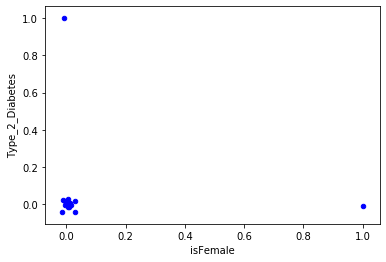

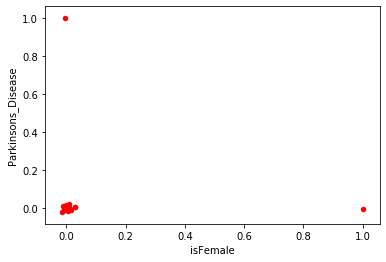

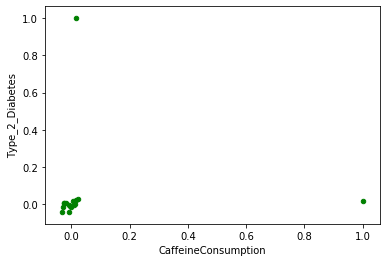

In [48]:
ax1 = correlation_df.plot.scatter(x='isFemale', y='Type_2_Diabetes', c='blue')
ax2 = correlation_df.plot.scatter(x='isFemale', y='Parkinsons_Disease', c='red')
ax3 = correlation_df.plot.scatter(x='CaffeineConsumption', y='Type_2_Diabetes', c='green')

In [49]:
#diseaseGlobe_df.plot.hist(alpha=0.5, figsize=(10,10))

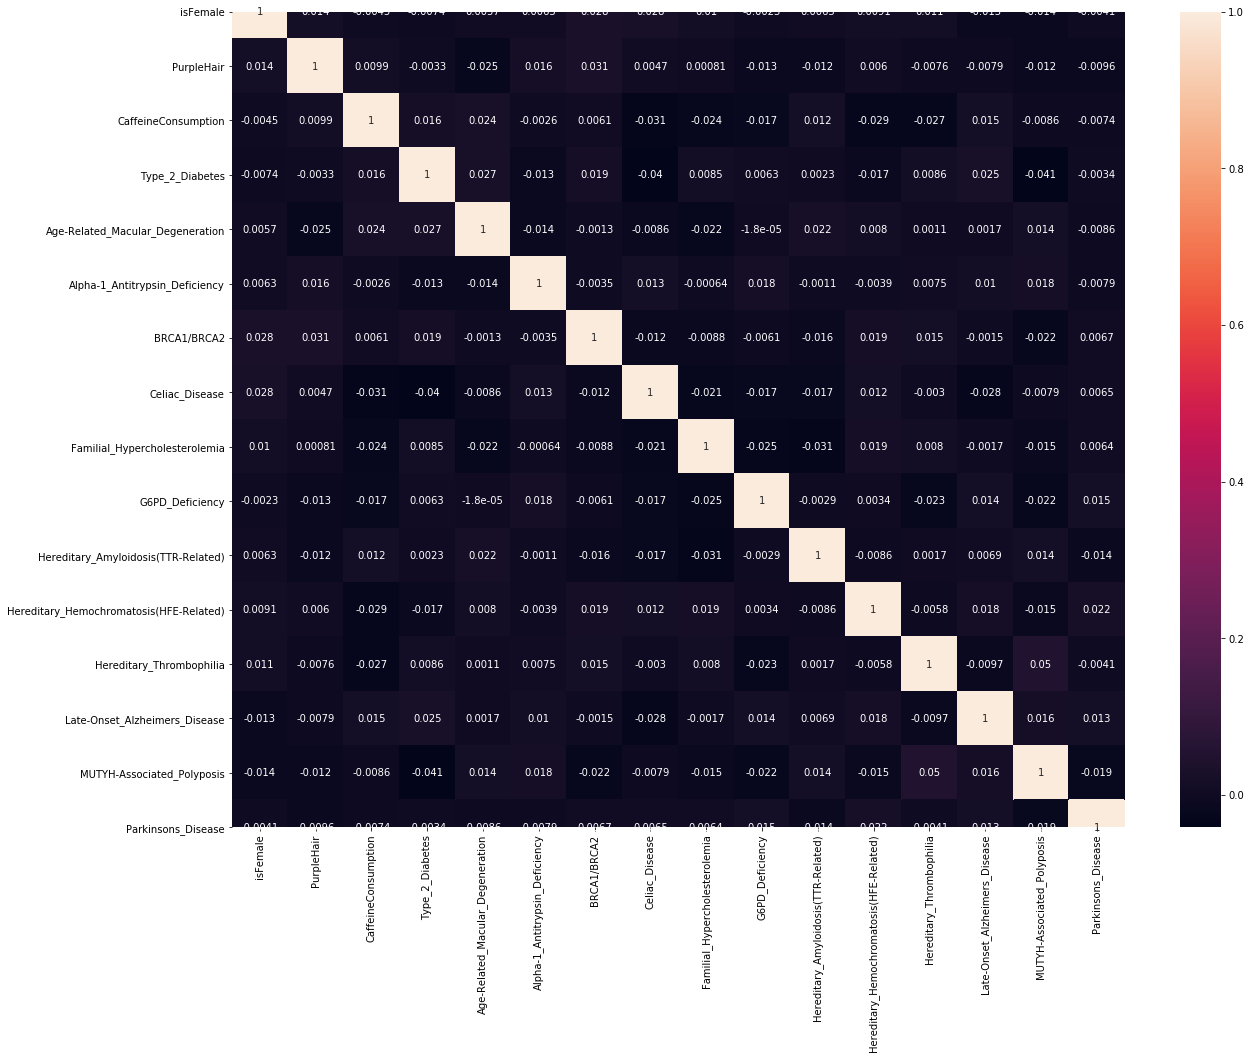

In [50]:
plt.subplots(figsize=(20,15))
sns.heatmap(correlation_df, annot=True)

## Add more conditions

In [53]:
num_rows = table.count()
#print("Number of rows in the table: ", num_rows)

# Add asthma
genome_pd_df["Asthma"] = [random.choice([True, False]) for i in range(num_rows)]

# Add HIV
genome_pd_df["HIV"] = [random.choice([True, False]) for i in range(num_rows)]

#Add Age
genome_pd_df["Age"] = [random.randint(0,99) for i in range(num_rows)]

In [54]:
genome_pd_df

,Sample,Population,SuperPopulation,isFemale,PurpleHair,CaffeineConsumption,Type_2_Diabetes,Age-Related_Macular_Degeneration,Alpha-1_Antitrypsin_Deficiency,BRCA1/BRCA2,...,G6PD_Deficiency,Hereditary_Amyloidosis(TTR-Related),Hereditary_Hemochromatosis(HFE‑Related),Hereditary_Thrombophilia,Late-Onset_Alzheimers_Disease,MUTYH-Associated_Polyposis,Parkinsons_Disease,Asthma,HIV,Age
0,HG00096,GBR,EUR,False,False,4,True,False,True,False,...,True,False,True,True,True,False,True,False,True,88
1,HG00097,GBR,EUR,True,True,4,False,False,False,True,...,True,True,False,True,False,False,False,True,False,95
2,HG00098,GBR,EUR,False,False,5,True,False,True,True,...,True,False,True,False,False,False,False,True,True,92
3,HG00099,GBR,EUR,True,False,4,False,False,True,True,...,False,False,True,True,True,True,True,False,True,27
4,HG00100,GBR,EUR,True,False,5,True,False,False,False,...,False,True,True,False,False,False,True,True,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,NA21137,GIH,SAS,True,False,1,True,True,True,True,...,True,False,True,True,False,True,True,False,False,85
3496,NA21141,GIH,SAS,True,True,2,True,False,False,False,...,True,False,True,True,True,True,False,True,True,27
3497,NA21142,GIH,SAS,True,True,2,False,False,False,False,...,True,False,True,False,False,False,True,False,False,85
3498,NA21143,GIH,SAS,True,True,5,False,True,False,True,...,False,True,False,True,False,True,True,True,False,98


In [55]:
correlation_df2 = genome_pd_df.corr()
correlation_df2

,isFemale,PurpleHair,CaffeineConsumption,Type_2_Diabetes,Age-Related_Macular_Degeneration,Alpha-1_Antitrypsin_Deficiency,BRCA1/BRCA2,Celiac_Disease,Familial_Hypercholesterolemia,G6PD_Deficiency,Hereditary_Amyloidosis(TTR-Related),Hereditary_Hemochromatosis(HFE‑Related),Hereditary_Thrombophilia,Late-Onset_Alzheimers_Disease,MUTYH-Associated_Polyposis,Parkinsons_Disease,Asthma,HIV,Age
isFemale,1.000000,0.014095,-0.004478,-0.007406,0.005701,0.006342,0.028311,0.027846,0.010325,-0.002332,0.006270,0.009098,0.011396,-0.013120,-0.014263,-0.004076,0.045783,-0.010332,-0.009973
PurpleHair,0.014095,1.000000,0.009908,-0.003291,-0.024666,0.016349,0.030800,0.004703,0.000811,-0.013430,-0.011535,0.006011,-0.007633,-0.007865,-0.012440,-0.009608,-0.042487,0.019734,-0.007031
CaffeineConsumption,-0.004478,0.009908,1.000000,0.016244,0.024362,-0.002611,0.006051,-0.031460,-0.023734,-0.017214,0.011945,-0.028628,-0.026635,0.014901,-0.008599,-0.007429,0.000059,-0.011506,0.016866
Type_2_Diabetes,-0.007406,-0.003291,0.016244,1.000000,0.026867,-0.012611,0.019094,-0.039901,0.008544,0.006318,0.002297,-0.016540,0.008594,0.025127,-0.041160,-0.003376,-0.014332,0.037176,0.033214
Age-Related_Macular_Degeneration,0.005701,-0.024666,0.024362,0.026867,1.000000,-0.014264,-0.001265,-0.008642,-0.021699,-0.000018,0.022279,0.007982,0.001130,0.001723,0.014295,-0.008602,-0.009117,-0.000018,-0.017367
Alpha-1_Antitrypsin_Deficiency,0.006342,0.016349,-0.002611,-0.012611,-0.014264,1.000000,-0.003494,0.012861,-0.000638,0.017793,-0.001115,-0.003923,0.007485,0.010247,0.018248,-0.007873,-0.007540,0.013222,0.010624
BRCA1/BRCA2,0.028311,0.030800,0.006051,0.019094,-0.001265,-0.003494,1.000000,-0.012412,-0.008795,-0.006144,-0.015600,0.019035,0.014577,-0.001506,-0.022106,0.006748,-0.007410,-0.011866,-0.007276
Celiac_Disease,0.027846,0.004703,-0.031460,-0.039901,-0.008642,0.012861,-0.012412,1.000000,-0.020952,-0.016812,-0.017234,0.011772,-0.003025,-0.028467,-0.007887,0.006477,0.007765,-0.022529,0.003601
Familial_Hypercholesterolemia,0.010325,0.000811,-0.023734,0.008544,-0.021699,-0.000638,-0.008795,-0.020952,1.000000,-0.025089,-0.031410,0.019485,0.008040,-0.001742,-0.015456,0.006377,-0.013794,0.012627,-0.023507
G6PD_Deficiency,-0.002332,-0.013430,-0.017214,0.006318,-0.000018,0.017793,-0.006144,-0.016812,-0.025089,1.000000,-0.002880,0.003365,-0.022904,0.014318,-0.022255,0.015325,0.000091,-0.021780,-0.021804


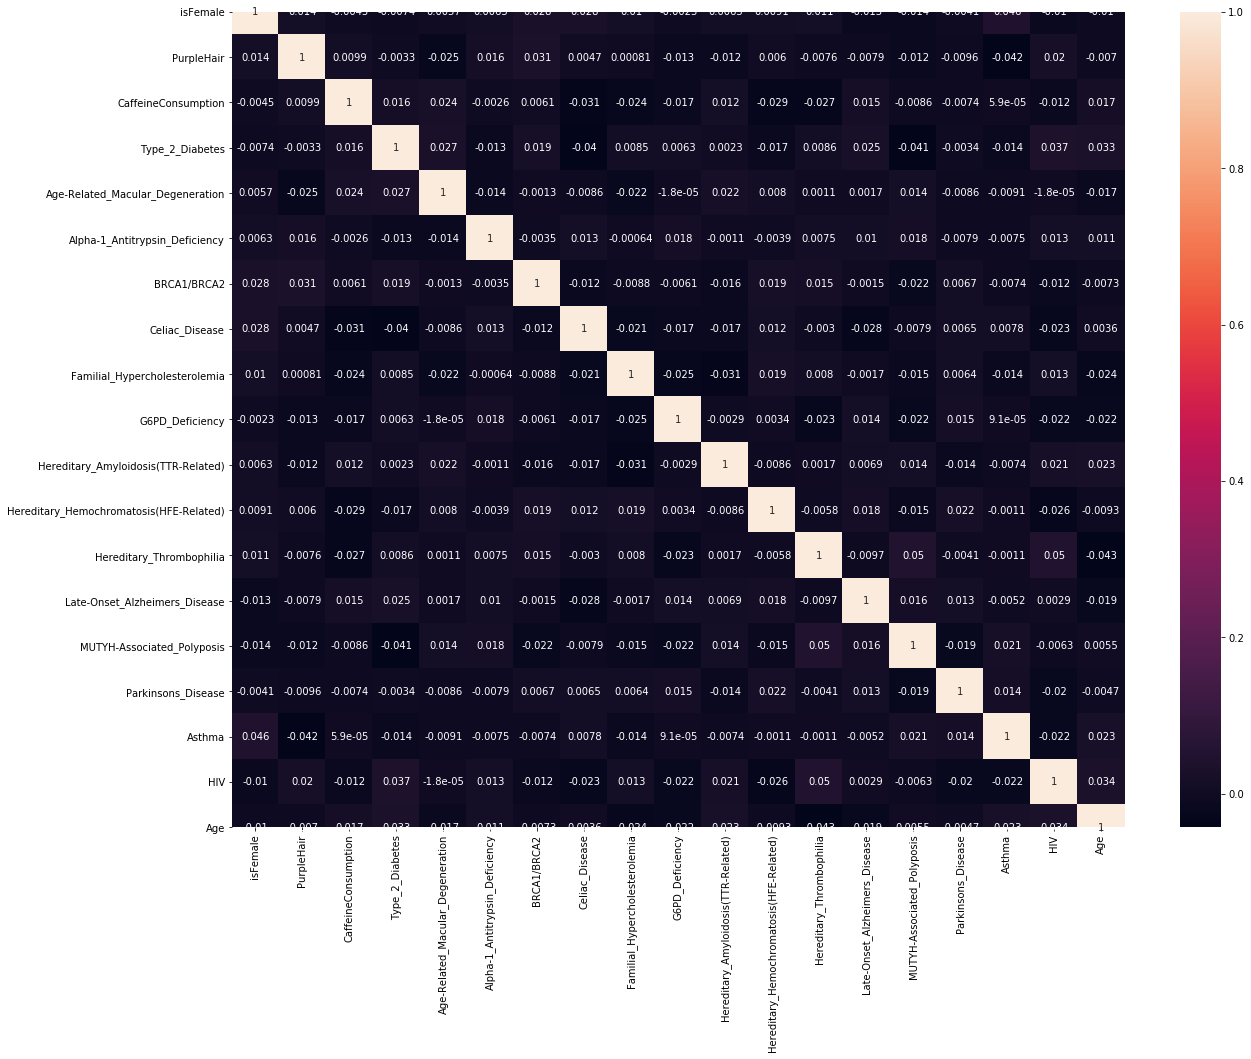

In [56]:
plt.subplots(figsize=(20,15))
sns.heatmap(correlation_df2, annot=True)

In [77]:
#Add blood type
blood_types = ["A+", "A-", "B+", "B-", "O+", "O-", "AB+", "AB-"]
genome_pd_df["BloodType"] = [random.choice(blood_types) for i in range(num_rows)]

#Add continuous feature - vitamin D level, from blood test
# glucose 	70-99 mg/dL (normal range)
#Adding normal range
genome_pd_df["Glucose(mg/dL)"] = [random.uniform(70, 99) for i in range(num_rows)]
# Adding unnormal range
for i in range(583):
    genome_pd_df.loc[i ,'Glucose(mg/dL)'] = random.uniform(10, 70) 
for i in range(583, 1166):
    genome_pd_df.loc[i ,'Glucose(mg/dL)'] = random.uniform(100, 300) 

# HDL 	 >60mg/dL(high)  men:<40mg/dL; women:<50mg/dL (low) 
# LDL 	 >160mg/dL(high)  <100mg/dL(low)
# Adding normal range for LDL and HDL
genome_pd_df["HDL(mg/dL)"] = [random.uniform(45, 60) for i in range(num_rows)]
genome_pd_df["LDL(mg/dL)"] = [random.uniform(100, 160) for i in range(num_rows)]
# Adding unnormal range 
for i in range(583):
    genome_pd_df.loc[i ,'HDL(mg/dL)'] = random.uniform(5, 45) 
for i in range(583, 1166):
    genome_pd_df.loc[i ,'HDL(mg/dL)'] = random.uniform(60, 100) 
    
for i in range(583):
    genome_pd_df.loc[i ,'LDL(mg/dL)'] = random.uniform(160, 400) 
for i in range(583, 1166):
    genome_pd_df.loc[i ,'LDL(mg/dL)'] = random.uniform(0, 100) 

In [78]:
genome_pd_df

,Sample,Population,SuperPopulation,isFemale,PurpleHair,CaffeineConsumption,Type_2_Diabetes,Age-Related_Macular_Degeneration,Alpha-1_Antitrypsin_Deficiency,BRCA1/BRCA2,...,Late-Onset_Alzheimers_Disease,MUTYH-Associated_Polyposis,Parkinsons_Disease,Asthma,HIV,Age,BloodType,Glucose(mg/dL),HDL(mg/dL),LDL(mg/dL)
0,HG00096,GBR,EUR,False,False,4,True,False,True,False,...,True,False,True,False,True,88,A-,18.430868,13.178005,257.086911
1,HG00097,GBR,EUR,True,True,4,False,False,False,True,...,False,False,False,True,False,95,A+,56.482967,30.654960,258.163207
2,HG00098,GBR,EUR,False,False,5,True,False,True,True,...,False,False,False,True,True,92,A+,33.493171,21.558603,246.029115
3,HG00099,GBR,EUR,True,False,4,False,False,True,True,...,True,True,True,False,True,27,A+,23.594134,17.035567,313.395370
4,HG00100,GBR,EUR,True,False,5,True,False,False,False,...,False,False,True,True,False,2,O+,57.684244,39.418264,253.325376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,NA21137,GIH,SAS,True,False,1,True,True,True,True,...,False,True,True,False,False,85,O+,97.060290,47.549795,148.207369
3496,NA21141,GIH,SAS,True,True,2,True,False,False,False,...,True,True,False,True,True,27,O+,78.702526,48.649258,131.590865
3497,NA21142,GIH,SAS,True,True,2,False,False,False,False,...,False,False,True,False,False,85,AB-,83.107839,50.776724,114.930695
3498,NA21143,GIH,SAS,True,True,5,False,True,False,True,...,False,True,True,True,False,98,A-,76.628276,56.343075,154.900122
